In [ ]:
# installing required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn geopy lightgbm


In [28]:
# importing required libraries and ML models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading our datasets
train_df = pd.read_csv('train_2.csv') # i am using smaller part of overall train data rows, hence using diffrent file name
test_df = pd.read_csv('test_.csv')
pincodes_df = pd.read_csv('pincodes.csv')

In [4]:
# Cleaning and preprocessing pincodes data
pincodes_df['Latitude'] = pincodes_df['Latitude'].str.extract(r'(\d+\.\d+|\d+)', expand=False)
pincodes_df['Latitude'] = pd.to_numeric(pincodes_df['Latitude'])
pincodes_df['Longitude'] = pincodes_df['Longitude'].str.extract(r'(\d+\.\d+|\d+)', expand=False)
pincodes_df['Longitude'] = pd.to_numeric(pincodes_df['Longitude'])
pincodes_df = pincodes_df[['Pincode', 'Latitude', 'Longitude']] # here, i have reduced the overall columns in pincodes data as it was taking longer time for processing

In [5]:
# Preprocessing train and test data
train_df['order_shipped_date'] = pd.to_datetime(train_df['order_shipped_date'])
train_df['order_delivered_date'] = pd.to_datetime(train_df['order_delivered_date'])
train_df['order_delivery_sla'] = (train_df['order_delivered_date'] - train_df['order_shipped_date']).dt.days

In [6]:
# This will handle any missing values
train_df.ffill(inplace=True)
test_df.ffill(inplace=True)
pincodes_df.ffill(inplace=True)

In [7]:
# colab was taking a good amount of memory, hence reducing memory usage here
train_df['pickup_pin_code'] = train_df['pickup_pin_code'].astype('category')
train_df['drop_pin_code'] = train_df['drop_pin_code'].astype('category')
test_df['pickup_pin_code'] = test_df['pickup_pin_code'].astype('category')
test_df['drop_pin_code'] = test_df['drop_pin_code'].astype('category')

In [8]:
# Merging pincodes with train and test data for getting geospatial info
train_df = train_df.merge(
    pincodes_df.rename(columns={'Pincode': 'pickup_pin_code', 'Latitude': 'pickup_lat', 'Longitude': 'pickup_long'}),
    on='pickup_pin_code',
    how='left'
)
train_df = train_df.merge(
    pincodes_df.rename(columns={'Pincode': 'drop_pin_code', 'Latitude': 'drop_lat', 'Longitude': 'drop_long'}),
    on='drop_pin_code',
    how='left'
)

test_df = test_df.merge(
    pincodes_df.rename(columns={'Pincode': 'pickup_pin_code', 'Latitude': 'pickup_lat', 'Longitude': 'pickup_long'}),
    on='pickup_pin_code',
    how='left'
)
test_df = test_df.merge(
    pincodes_df.rename(columns={'Pincode': 'drop_pin_code', 'Latitude': 'drop_lat', 'Longitude': 'drop_long'}),
    on='drop_pin_code',
    how='left'
)

In [9]:
# Optimizing distance calculation using vectorized Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

train_df['distance'] = haversine(
    train_df['pickup_lat'], train_df['pickup_long'], train_df['drop_lat'], train_df['drop_long']
)
test_df['distance'] = haversine(
    test_df['pickup_lat'], test_df['pickup_long'], test_df['drop_lat'], test_df['drop_long']
)


In [10]:
# Time for Feature engineering
train_df['month'] = train_df['order_shipped_date'].dt.month
train_df['day_of_week'] = train_df['order_shipped_date'].dt.dayofweek
train_df['is_weekend'] = train_df['day_of_week'] >= 5

# This will convert 'order_shipped_date' to datetime in test_df before using .dt accessor(output was giving error for the same)
test_df['order_shipped_date'] = pd.to_datetime(test_df['order_shipped_date'])

test_df['month'] = test_df['order_shipped_date'].dt.month
test_df['day_of_week'] = test_df['order_shipped_date'].dt.dayofweek
test_df['is_weekend'] = test_df['day_of_week'] >= 5

# Adding courier performance features
courier_avg_sla = train_df.groupby('courier_partner_id')['order_delivery_sla'].mean().reset_index()
courier_avg_sla.columns = ['courier_partner_id', 'avg_sla']
train_df = train_df.merge(courier_avg_sla, on='courier_partner_id', how='left')
test_df = test_df.merge(courier_avg_sla, on='courier_partner_id', how='left')

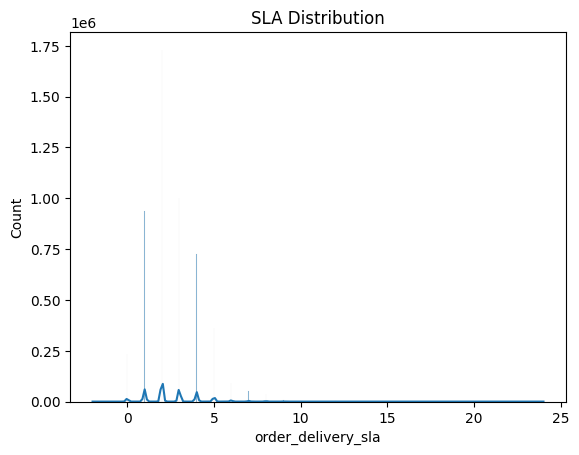

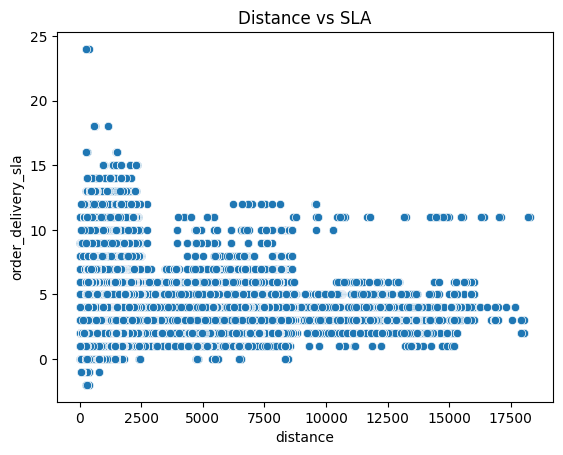

In [11]:
# Some data visualization
# SLA Distribution
sns.histplot(train_df['order_delivery_sla'], kde=True)
plt.title("SLA Distribution")
plt.show()

# Distance vs SLA
sns.scatterplot(data=train_df, x='distance', y='order_delivery_sla')
plt.title("Distance vs SLA")
plt.show()


In [12]:
# Feature scaling, here i am basically Standardizing the feature set for improved performance with Gradient Boosting and LightGBM
scaler = StandardScaler()
features = ['distance', 'quantity', 'avg_sla', 'month', 'day_of_week', 'is_weekend']
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

In [13]:
# spliting train data into trainig and validating data
X = train_df[features]
y = train_df['order_delivery_sla']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # using this here as GradientBoosting cannot handle NaN value

# Fitting the imputer on the training data and transforming both train and validation sets
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)


# Using Voting Regressor
gbr = GradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
model = VotingRegressor([('gbr', gbr), ('lgbm', lgbm)])

model.fit(X_train, y_train)

In [17]:
# Evaluating on validation set
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Validation RMSE: 1.130946661153999


In [ ]:
# Predicting on Test Data
# Imputing missing values in the test data using the same imputer fitted on the training data
test_data_imputed = imputer.transform(test_df[features])

test_df['predicted_exact_sla'] = model.predict(test_data_imputed)

# Saving submission file
submission = test_df[['id', 'predicted_exact_sla']]
submission.to_csv('submission.csv', index=False)

In [23]:
submission_df = pd.read_csv('submission.csv')
submission_df

,id,predicted_exact_sla
0,428365149,3.473773
1,428365149,1.979594
2,428365149,2.022653
3,428365149,1.979594
4,428365149,2.022653
...,...,...
20423382,449337435,3.368831
20423383,449337435,3.493046
20423384,449337625,2.293172
20423385,449337625,2.293172


In [26]:
submission_df = submission_df.drop_duplicates('id')

In [27]:
submission_df

,id,predicted_exact_sla
0,428365149,3.473773
78,428365152,1.702816
210,428365154,1.924286
270,428365156,1.413880
456,428365161,2.091549
...,...,...
20423354,449337059,2.826714
20423366,449337196,3.499317
20423372,449337197,3.546866
20423381,449337435,3.362592
